In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree

In [2]:
# Создаём обучающую выборку
ames_data = pd.read_csv('data/AmesHousing.csv')
ames_data = ames_data[(ames_data['Lot Frontage'] <=150) & (ames_data['Lot Area'] <=20000)]
X = ames_data[['Lot Frontage', 'Lot Area']]
y = ames_data['SalePrice']

In [3]:
# Инициализируем модель дерева решений с максимальной глубиной 3 и обучаем её
dt_reg = tree.DecisionTreeRegressor(max_depth=3)
dt_reg.fit(X.values, y)

DecisionTreeRegressor(max_depth=3)

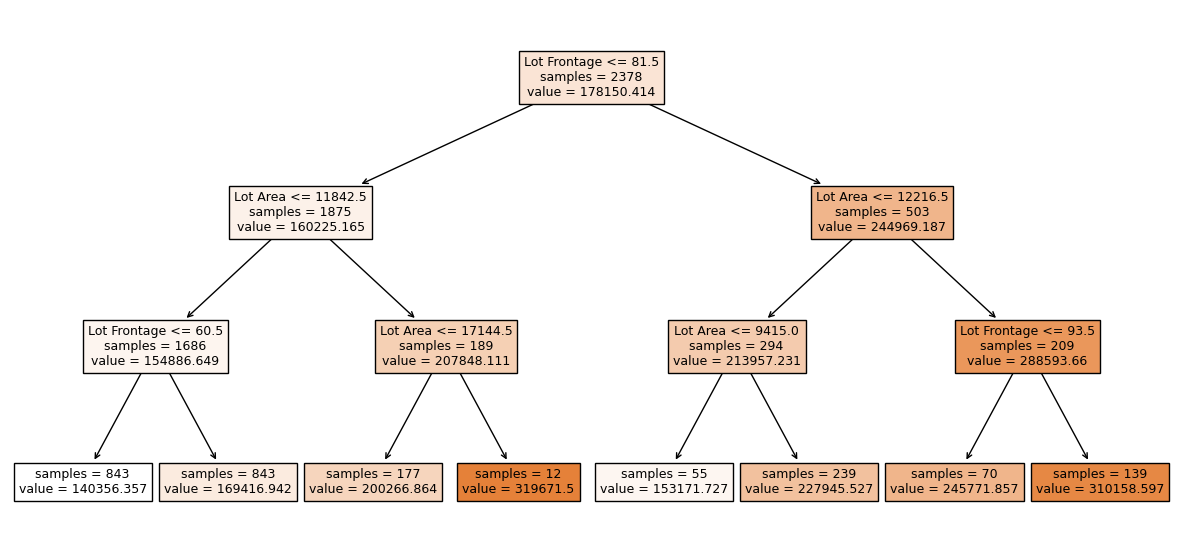

In [4]:
# Визуализируем дерево решений в виде графа
fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    dt_reg, #дерево решений 
    feature_names=X.columns, #имена факторов
    filled=True, #расцветка
    impurity=False, #отображать ли неоднородность
);

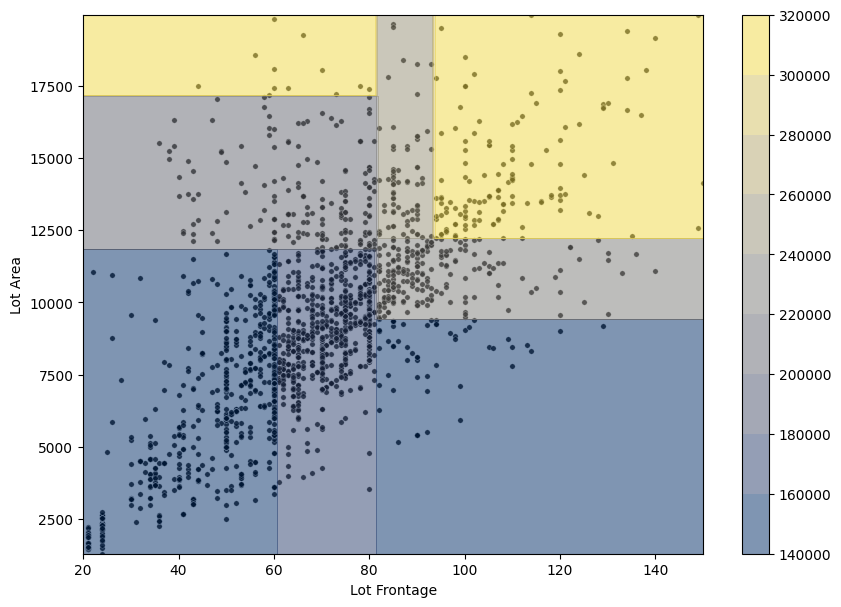

In [5]:
def plot_decision_bound_regression(X, y, model, fig):
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 1)
    )
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    y_pred = model.predict(X_net)
    y_pred = y_pred.reshape(xx1.shape)
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], s=15, color='black', alpha=0.8)
    contour = plt.contourf(xx1, xx2, y_pred, 10, cmap='cividis', alpha=0.5)
    fig.colorbar(contour)

# Визуализируем разделяющую поверхность дерева решений
fig = plt.figure(figsize = (10, 7))
plot_decision_bound_regression(X, y, dt_reg, fig)

In [6]:
# Создаём обучающую выборку    
bill_data = pd.read_csv('data/bill_authentication.csv')
X = bill_data[['Variance', 'Skewness']]
y = bill_data['Class']

In [7]:
# Инициализируем модель дерева решений с максимальной глубиной 4 и обучаем её
dt_clf = tree.DecisionTreeClassifier(max_depth=4)
dt_clf.fit(X.values, y)

DecisionTreeClassifier(max_depth=4)

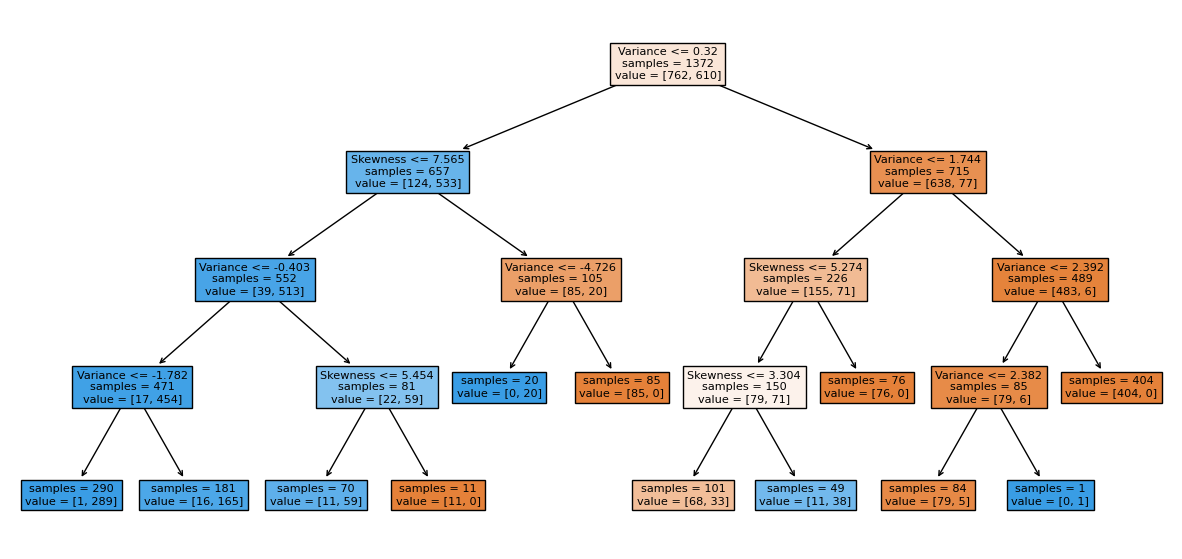

In [8]:
# Визуализируем дерево решений в виде графа
fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    dt_clf, #дерево решений
    feature_names=X.columns, #имена факторов
    filled=True, #расцветка
    impurity=False, #отображать ли неоднородность
);


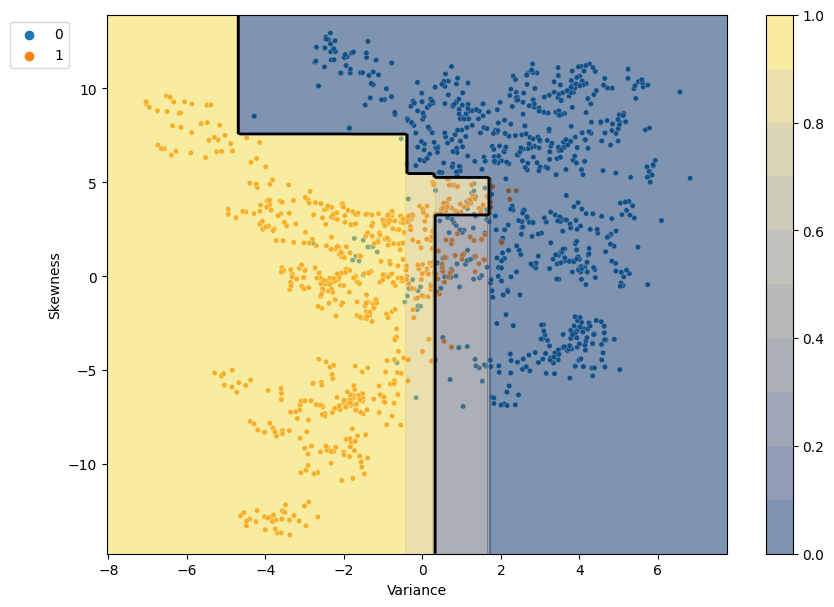

In [9]:
def plot_decision_bound_classification(X, y, model, fig):
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    probs = model.predict_proba(X_net)[:, 1]
    probs = probs.reshape(xx1.shape)
    
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, s=15, alpha=1)
    contour = plt.contourf(xx1, xx2, probs, 10, cmap='cividis', alpha=0.5)
    bound = plt.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    fig.colorbar(contour)
    plt.legend(bbox_to_anchor=(-0.05, 1))
# Визуализируем разделяющую поверхность дерева решений
fig = plt.figure(figsize = (10, 7))
plot_decision_bound_classification(X, y, dt_clf, fig)

In [10]:
ames_data = pd.read_csv('data/AmesHousing.csv')
ames_data = ames_data[(ames_data['Lot Frontage'] <=150) & (ames_data['Lot Area'] <=20000)]
ames_sample = ames_data[['Lot Frontage', 'Lot Area', 'SalePrice']].sample(
    n=15, #количество объектов
    random_state=42, #генератор случайных чисел
    ignore_index=True #сбрасываем счетчик индекса
)

In [11]:
ames_sample.head(3)

,Lot Frontage,Lot Area,SalePrice
0,60.0,11040,108000
1,96.0,10628,193000
2,68.0,9717,142125


In [12]:
def find_candidates_for_thresholds(x, y):
    x = x.sort_values().drop_duplicates()
    x_roll_mean = x.rolling(2).mean().dropna()
    y = y[x_roll_mean.index]
    y_roll_mean = y.diff()
    candidates = x_roll_mean[y_roll_mean != 0]
    return candidates.values

print(find_candidates_for_thresholds(ames_sample['Lot Frontage'], ames_sample['SalePrice']))

[ 53.  58.  61.  65.  69.  71.  76.  86.  94. 101.]


In [13]:
print(find_candidates_for_thresholds(ames_sample['Lot Area'], ames_sample['SalePrice']))

[ 5508.   7153.   7425.   7949.   8405.5  8526.5  8850.   9137.5  9466.
 10051.5 10507.  10834.  11365.  12288. ]


In [14]:

X = ames_sample[['Lot Frontage', 'Lot Area']]
y = ames_sample["SalePrice"]

In [15]:
def squared_error(y):
    y_pred = y.mean()
    return ((y - y_pred) ** 2).mean()

def split(X, y, split_params):
    j, t = split_params
    predicat = X.iloc[:, j] <= t
    X_left, y_left = X[predicat], y[predicat]
    X_right, y_right = X[~predicat], y[~predicat]
    return X_left, y_left, X_right, y_right

def calculate_weighted_impurity(X, y, split_params, criterion):
    X_left, y_left, X_right, y_right = split(X, y, split_params)
    N, N_left, N_right  = y.size, y_left.size, y_right.size
    score = N_left / N * criterion(y_left) + N_right / N * criterion(y_right)
    return score

def best_split(X, y, criterion):
    M = X.shape[1]
    min_weighted_impurity = np.inf
    optimal_split_params = None
    for j in range(M):
        thresholds = find_candidates_for_thresholds(X.iloc[:, j], y)
        for t in thresholds:
            split_params = (j, t)
            weighted_impurity = calculate_weighted_impurity(X, y, split_params, criterion)
            if weighted_impurity < min_weighted_impurity:
                min_weighted_impurity = weighted_impurity
                optimal_split_params = split_params
    return optimal_split_params

Optimal j: 0
Optimal t: 71
Weighted impurity: 1414654917


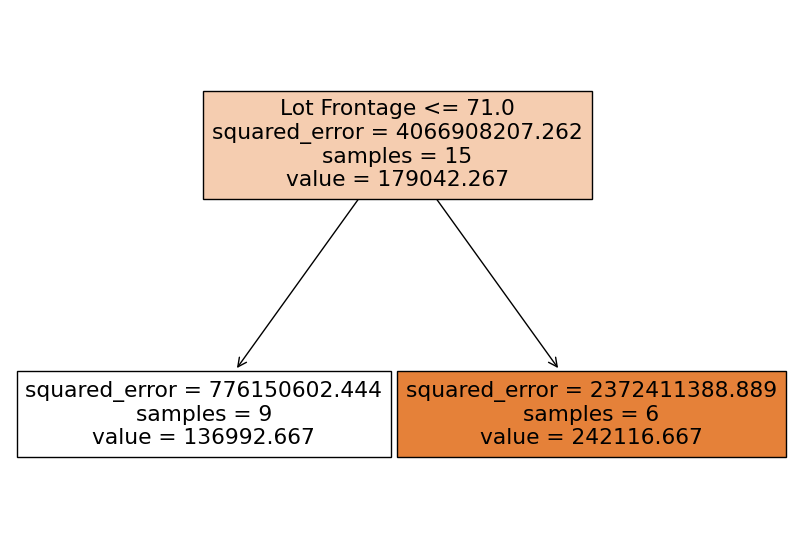

In [16]:
optimal_params = best_split(X, y, criterion=squared_error)
print('Optimal j: {}'.format(optimal_params[0]))
print('Optimal t: {:.0f}'.format(optimal_params[1]))
print('Weighted impurity: {:.0f}'.format(calculate_weighted_impurity(X, y, optimal_params, criterion=squared_error)))

# Инициализируем модель дерева решений с максимальной глубиной 1 и обучаем её
dt = tree.DecisionTreeRegressor(max_depth=1, criterion='squared_error', random_state=0)
dt.fit(X, y)
# Визуализируем дерево решений в виде графа
fig = plt.figure(figsize = (10, 7))
tree.plot_tree(
    decision_tree=dt, #дерево решений 
    feature_names=X.columns, #названия факторов
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
);

In [17]:
def entropy(y):
    p = y.value_counts(normalize=True)
    entropy = -np.sum(p * np.log2(p))
    return entropy

In [18]:
bill_data = pd.read_csv('data/bill_authentication.csv')
bill_sample = bill_data[['Variance', 'Skewness', 'Class']].sample(
    n=15, 
    random_state=42, 
    ignore_index=True
)
# Создаём обучающую выборку
X = bill_sample[['Variance', 'Skewness']]
y = bill_sample['Class']

Optimal j: 1
Optimal t: 3.221
Impurity: 0.460


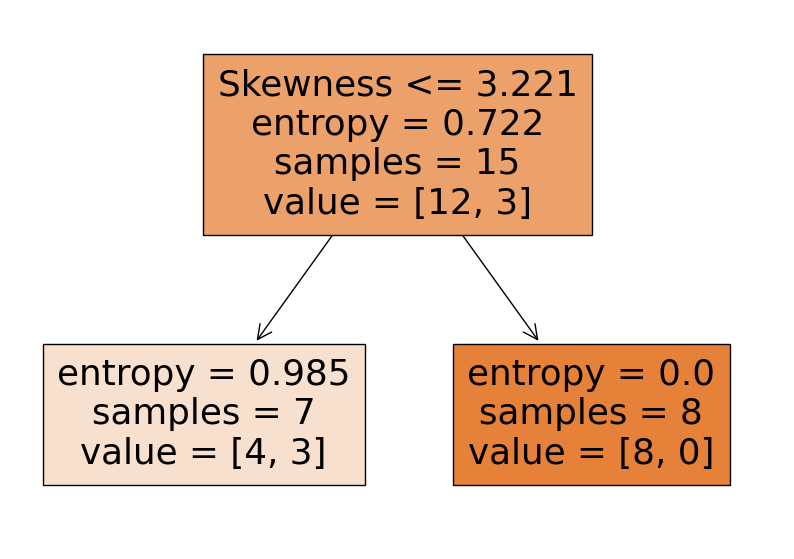

In [19]:
# Находим оптимальные параметры разбиения
optimal_params = best_split(X, y, criterion=entropy)
print('Optimal j: {}'.format(optimal_params[0]))
print('Optimal t: {:.3f}'.format(optimal_params[1]))
print('Impurity: {:.3f}'.format(calculate_weighted_impurity(X, y, optimal_params, criterion=entropy)))

# Инициализируем модель дерева решений с максимальной глубиной 1 и обучаем её
dt = tree.DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
dt.fit(X, y)
# Визуализируем дерево решений в виде графа
fig = plt.figure(figsize = (10, 7))
tree.plot_tree(
    decision_tree=dt, #дерево решений 
    feature_names=X.columns, #названия факторов
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
);

In [20]:
class Node:
    def __init__(self, left=None, 
                 right=None, value=None, 
                 split_params=None, impurity=None,
                 samples=None, is_leaf=False):
        self.left = left
        self.right = right
        self.split_params = split_params
        self.value = value
        self.impurity = impurity
        self.samples = samples
        self.is_leaf = is_leaf

def create_leaf_prediction(y):
    value = y.mode()[0]
    return value

def stopping_criterion(X, y, criterion):
    return criterion(y) == 0

def build_decision_tree(X, y, criterion):
    if stopping_criterion(X, y, criterion):
        value = create_leaf_prediction(y)
        node = Node(
            value=value, 
            impurity=criterion(y), 
            samples=y.size,
            is_leaf=True
        )
    else:
        split_params = best_split(X, y, criterion=entropy)
        X_left, y_left, X_rigth, y_right = split(X, y, split_params)
        left = build_decision_tree(X_left, y_left, criterion)
        right = build_decision_tree(X_rigth, y_right, criterion)       
        node = Node(
            left=left, right=right, 
            split_params=split_params, 
            impurity=criterion(y), 
            samples=y.size
        )
    return node

def print_decision_tree(node, depth=0):
    depth += 1
    if node.is_leaf:
        print('   ' * depth, 'class: {}'.format(node.value))
    else:
        print('   ' * depth, 'feature_{} <= {:.3f}:'.format(*node.split_params))
        print_decision_tree(node.left, depth=depth)
        print('   ' * depth, 'feature_{} > {:.3f}:'.format(*node.split_params))
        print_decision_tree(node.right, depth=depth)
        
# Создаем обучающую выборку
data = pd.DataFrame({
    'age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31],
    'income': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102],
    'loan': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
})
X = data[['age', 'income']]
y = data['loan'] 
# Строим дерево решений и печатаем его на экран
decision_tree = build_decision_tree(X, y, criterion=entropy)
print_decision_tree(decision_tree)

    feature_0 <= 43.500:
       feature_1 <= 86.000:
          feature_0 <= 22.500:
             feature_0 <= 19.000:
                class: 1
             feature_0 > 19.000:
                class: 0
          feature_0 > 22.500:
             class: 1
       feature_1 > 86.000:
          class: 0
    feature_0 > 43.500:
       class: 0


In [21]:
bill_data = pd.read_csv('data/bill_authentication.csv')
bill_sample = bill_data[['Variance', 'Skewness', 'Class']].sample(
    n=15, 
    random_state=42, 
    ignore_index=True
)
# Создаём обучающую выборку
X = bill_sample[['Variance', 'Skewness']]
y = bill_sample['Class']

In [22]:
X.head()

,Variance,Skewness
0,1.569100,6.3465
1,-0.278020,8.1881
2,0.051979,7.0521
3,-1.755900,11.9459
4,2.428700,9.3821


In [23]:
decision_tree = build_decision_tree(X, y, criterion=entropy)
print_decision_tree(decision_tree)

    feature_1 <= 3.221:
       feature_0 <= 2.756:
          feature_0 <= -1.254:
             class: 0
          feature_0 > -1.254:
             feature_0 <= -0.063:
                class: 1
             feature_0 > -0.063:
                feature_0 <= 0.988:
                   class: 0
                feature_0 > 0.988:
                   class: 1
       feature_0 > 2.756:
          class: 0
    feature_1 > 3.221:
       class: 0


In [24]:
data = pd.DataFrame({
    'age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31],
    'income': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102],
    'y': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
})
# Создаём обучающую выборку
X = data[['age', 'income']]
y = data['y']

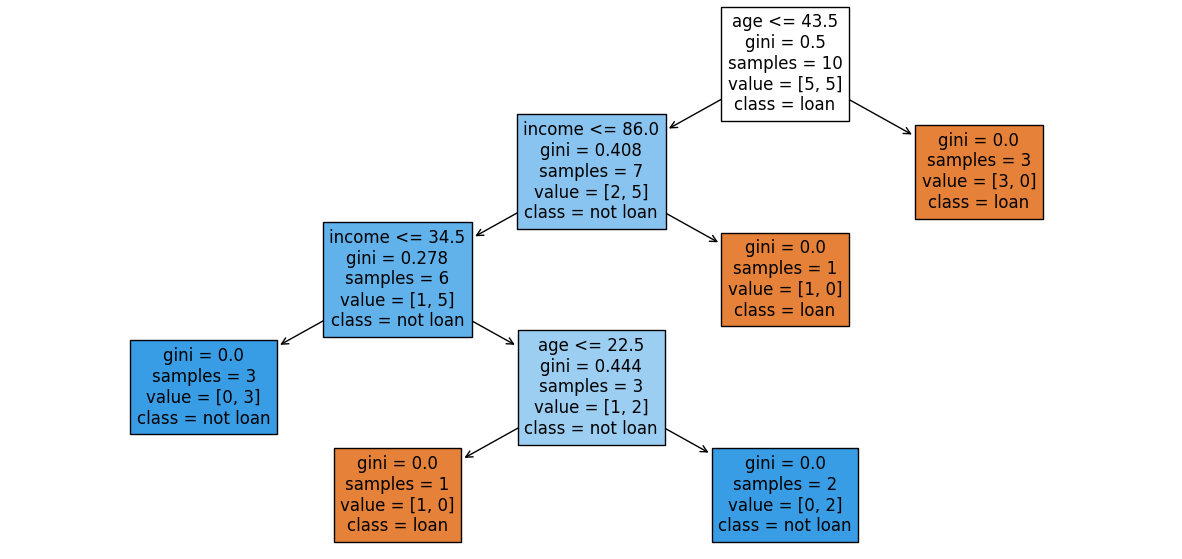

In [25]:
dt = tree.DecisionTreeClassifier(random_state=42)
dt.fit(X, y)


fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, 
    feature_names=X.columns, 
    class_names=['loan', 'not loan'], 
    filled=True, 
    impurity=True
);

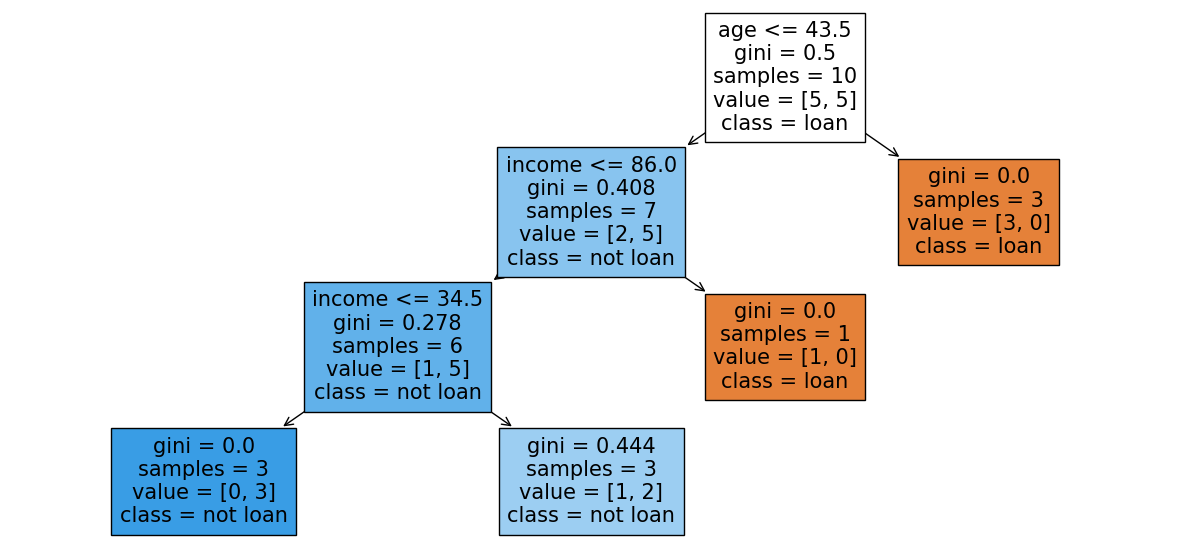

In [26]:
dt = tree.DecisionTreeClassifier(
    max_depth=3, 
    random_state=42
)
dt.fit(X, y)


fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, 
    feature_names=X.columns, 
    class_names=['loan', 'not loan'], 
    filled=True, 
    impurity=True
);

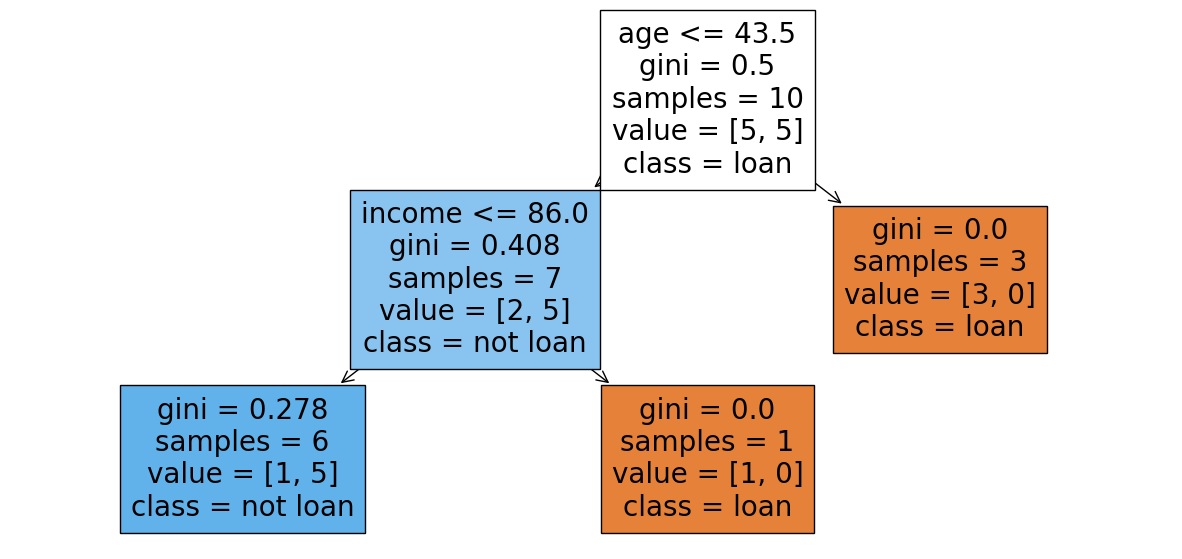

In [27]:
dt = tree.DecisionTreeClassifier(
    max_leaf_nodes=3, 
    random_state=42
)
dt.fit(X, y)


fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, 
    feature_names=X.columns, 
    class_names=['loan', 'not loan'], 
    filled=True, 
    impurity=True
);

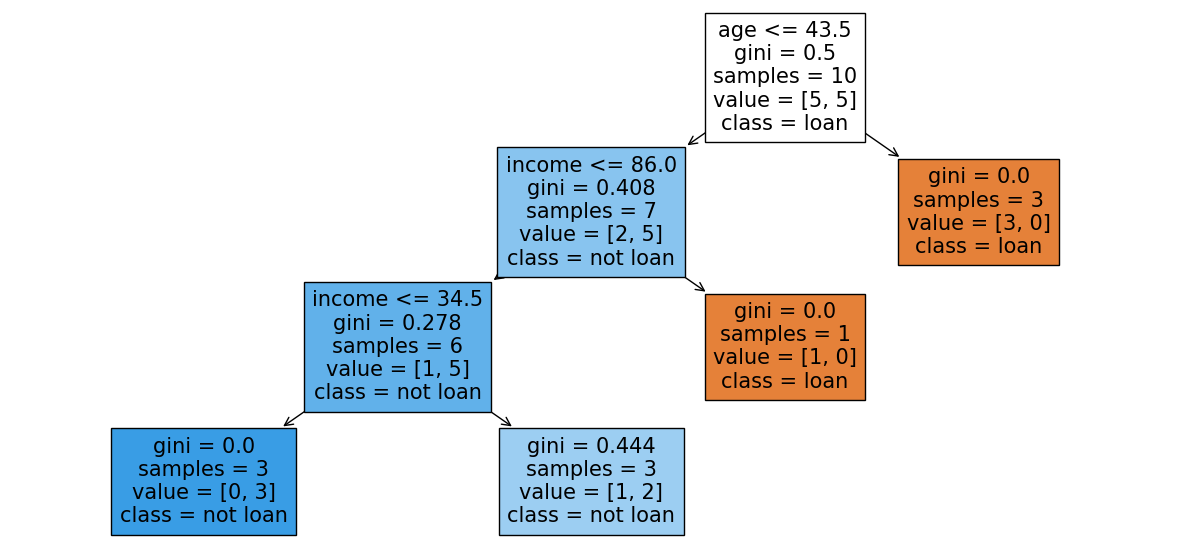

In [28]:
dt = tree.DecisionTreeClassifier(
    min_samples_split=6, 
    random_state=42
)
dt.fit(X, y)


fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, 
    feature_names=X.columns, 
    class_names=['loan', 'not loan'], 
    filled=True, 
    impurity=True
);

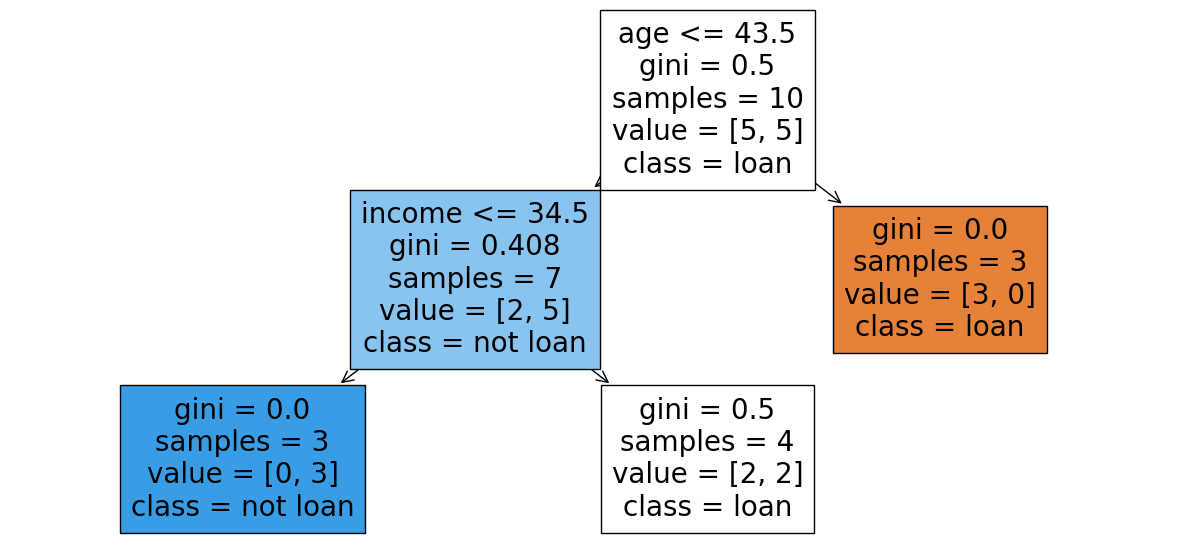

In [29]:
dt = tree.DecisionTreeClassifier(
    min_samples_leaf=3, 
    random_state=42
)
dt.fit(X, y)


fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, 
    feature_names=X.columns, 
    class_names=['loan', 'not loan'], 
    filled=True, 
    impurity=True
);

In [30]:
def stopping_criterion(X, y, criterion, max_depth=None, depth=0):
    if max_depth is None:
        return (criterion(y) == 0) 
    else:
        return (criterion(y) == 0) or (depth > max_depth)
    
def build_decision_tree(X, y, criterion, max_depth=None, depth=0):
    depth += 1
    if stopping_criterion(X, y, criterion, max_depth, depth):
        value = create_leaf_prediction(y)
        node = Node(
            value=value, 
            impurity=criterion(y), 
            samples=y.size,
            is_leaf=True
        )
    else:
        split_params = best_split(X, y, criterion=entropy)
        X_left, y_left, X_right, y_right = split(X, y, split_params)
        left = build_decision_tree(X_left, y_left, criterion, max_depth, depth)
        right = build_decision_tree(X_right, y_right, criterion, max_depth, depth)       
        node = Node(
            left=left, right=right, 
            split_params=split_params, 
            impurity=criterion(y), 
            samples=y.size
        )
    return node

In [31]:
# Строим дерево решений с ограничением глубины и выводим его на экран
decision_tree = build_decision_tree(X, y, criterion=entropy, max_depth=2)
print_decision_tree(decision_tree)

    feature_0 <= 43.500:
       feature_1 <= 86.000:
          class: 1
       feature_1 > 86.000:
          class: 0
    feature_0 > 43.500:
       class: 0
